In [1]:
## path to datasets
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Power grid graph

This is a test of robustness of an empirical graph that does not exhibit power law.

Network robustness is an important practical topic for power grids.

First we load data

In [3]:
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()
## read the vertices along with some attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()]
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

We want to concentrate on an Iberic peninsula. Note that we select a giant component of the graph selected by latitude and longitude as e.g. nodes located on islands are isolated.

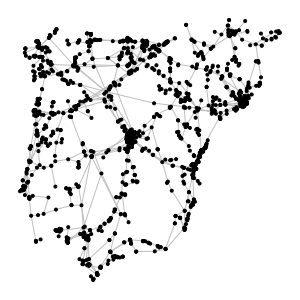

In [4]:
## subgraph of Grid -- giant component on Iberic peninsula
V = [v for v in gr.vs() if v['latitude']>36 and v['latitude']<44 and v['longitude']>-10 and v['longitude']<4]
gr_spain = gr.subgraph(V).clusters().giant()
ly = ig.Layout(gr_spain.vs['layout'])
ly.mirror(1)
ig.plot(gr_spain, 'grid_iberic_giant.eps', layout=ly, bbox=(0,0,300,300))

We check the node count and average node degree 

In [5]:
gr_spain.vcount()

1537

In [6]:
np.mean(gr_spain.degree())

2.5530253741054003

This function given a graph `gr` tests removing nodes from this graph until `stop_count` nodes are left.
If `rnd` is `True` then we assume random failure model. If `rnd` is `False` then we assume targetted attack, in which sequentially a node with the highest degree in the remaining network is removed.

The function returns order parameter sequence (i.e. the fraction of nodes in the giant component of the remaining graph) and the final graph.

In [7]:
def single_run(gr, rnd, stop_count=1):
    gr = gr.copy()
    order = [1.0]
    while gr.vcount() > stop_count:
        if rnd:
            to_delete = random.randint(0, gr.vcount() - 1)
        else:
            # here we hadnle the case that there might be multiple nodes with maximum degreee
            m = max(gr.degree())
            am = [i for i, j in enumerate(gr.degree()) if j == m]
            to_delete = random.choice(am)
        gr.delete_vertices(to_delete)
        order.append(gr.clusters().giant().vcount() / gr.vcount())
    return order, gr

We run both options (`rnd` equal to `True` and to `False`) 16 times and report the average result as `single_run` is randomized. Note that `rnd=True` leads to much lower variability.

In [8]:
res_rnd = [single_run(gr_spain, True)[0] for i in range(16)]

In [9]:
res_attack = [single_run(gr_spain, False)[0] for i in range(16)]

Observe that order parameter:
1. Falls much faster when `rnd=True`
2. When almost all nodes are removed order parameter increases, but this is a case that is not very interesting (we are mostly interested in the left parts of the plots)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


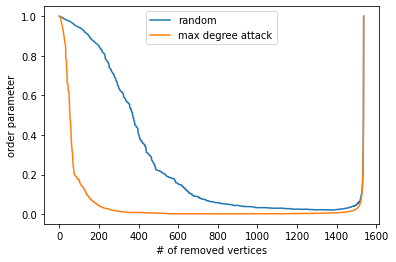

In [10]:
plt.plot(np.average(res_rnd, axis=0))
plt.plot(np.average(res_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random", "max degree attack"])
plt.savefig('op_power_grid.eps', format='eps')

We test a single scenario under maximum degree attack when 5% of nodes are removed. Colors on the plot represent different components of the graph.

In [11]:
_, gr_sel = single_run(gr_spain, False, gr_spain.vcount()*0.95)

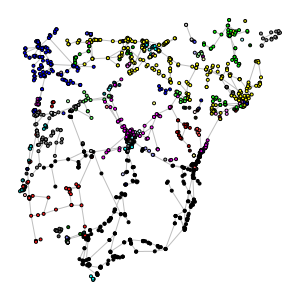

In [12]:
ly = ig.Layout(gr_sel.vs['layout'])
ly.mirror(1)
ig.plot(gr_sel.clusters(), 'grid_iberic_5pct_attack.eps', layout=ly, bbox=(0,0,300,300))

Check the number of components

In [13]:
len(gr_sel.clusters().sizes())

127

And distribution of their sizes. We can see that we have two relatively large components and many tiny components.

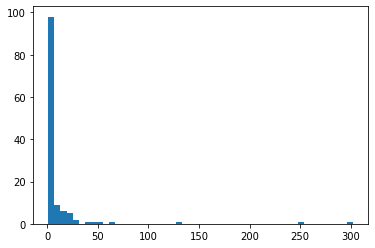

In [14]:
plt.hist(gr_sel.clusters().sizes(), 50);

In [15]:
df = pd.DataFrame({'size': gr_sel.clusters().sizes()})

In [16]:
df['size'].value_counts().sort_index()

1      51
2      18
3       7
4       8
5       4
6       3
7       7
8       2
9       2
10      2
11      1
12      1
13      1
14      3
15      2
19      1
20      2
22      1
23      2
27      1
29      1
41      1
47      1
52      1
62      1
132     1
252     1
302     1
Name: size, dtype: int64

# Power law

Here we investigate the scenario where we simulate a graph whose degree distribution follows the power law

In [17]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

As above - we analyze the giant component of such a graph

In [18]:
## power law graph
gamma = 3
n = 2000
delta = 1
Delta = np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g = ig.Graph.TupleList(tpl).clusters().giant()

The graph has comparable number of nodes and average degree to the grid graph above.

In [19]:
g.vcount()

1345

In [20]:
np.mean(g.degree())

2.658736059479554

In [21]:
g_rnd = [single_run(g, True)[0] for i in range(16)]

In [22]:
g_attack = [single_run(g, False)[0] for i in range(16)]

Note that for a random graph whose degree distribution follows a power law there is much larger difference between random failure and max degree attack models.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


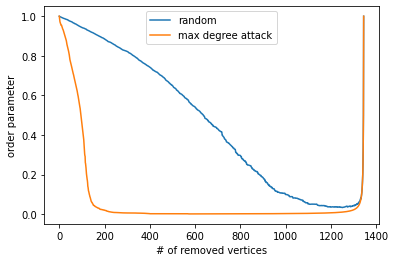

In [23]:
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random", "max degree attack"])
plt.savefig('op_power_law.eps', format='eps')

# Assortative

Next we turn our analysis to checking how network assortativity influences the order parameter.

In [24]:
## Xulvi-Brunet and Sokolov algorithm
def XBS(n, d, q, assortative):
    p = d/n
    g = ig.Graph.Erdos_Renyi(n,p)
    g.es['touched'] = False
    ec = g.ecount()
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount():
            break
    return g

In the scenarios we again make the graphs to have a comparable number of nodes and average degree to grid network.

Positive assortativity scenario

node count: 1469
mean degree: 2.89857045609258


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


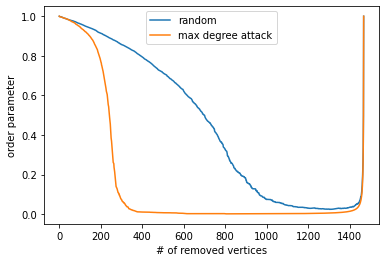

In [25]:
g = XBS(1800, 2.4, 2/3, True).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random", "max degree attack"])
plt.savefig('op_positive_ass.eps', format='eps')

Negative assortivity scenario

node count: 1635
mean degree: 2.7021406727828747


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


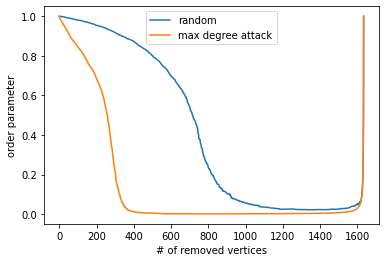

In [26]:
g = XBS(1800, 2.4, 2/3, False).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random", "max degree attack"])
plt.savefig('op_negative_ass.eps', format='eps')

No assortivity scenario

node count: 1575
mean degree: 2.6933333333333334


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


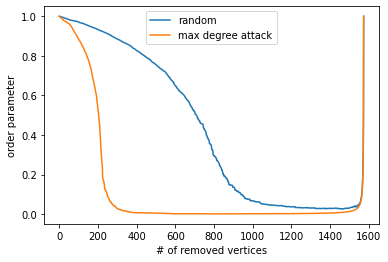

In [27]:
g = XBS(1800, 2.4, 0, True).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random", "max degree attack"])
plt.savefig('op_no_ass.eps', format='eps')

We can observe that for random failure model the higher assortativity makes the decreas of order parameter more evenly distributed.

For maximum degree attack scenario we note the reverse - lower assortativity leads to more evenly distributed decerase of order parameter.

# Communities

The last experiment we perform is with a graph that contains communities. We used ABCD graph generator with $\xi\in\{0.1,0.4,0.7,1.0\}$.

Again we tune the graphs to roughly follow the node count and average node degree of a grid graph.

node count: 1330
mean degree: 3.0977443609022557


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


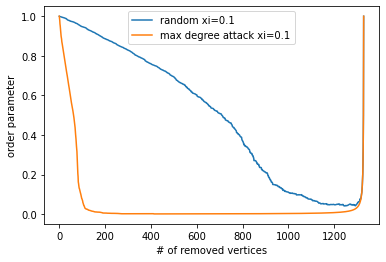

In [28]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/edge01.dat',directed=False).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random xi=0.1", "max degree attack xi=0.1"])
plt.savefig('op_community01.eps', format='eps')

node count: 1214
mean degree: 2.9077429983525533


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


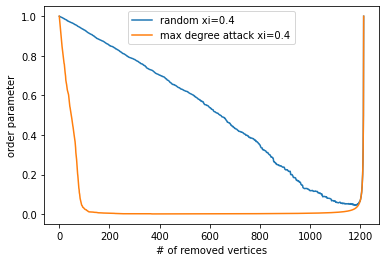

In [29]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/edge04.dat',directed=False).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random xi=0.4", "max degree attack xi=0.4"])
plt.savefig('op_community04.eps', format='eps')

node count: 1255
mean degree: 3.0597609561752988


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


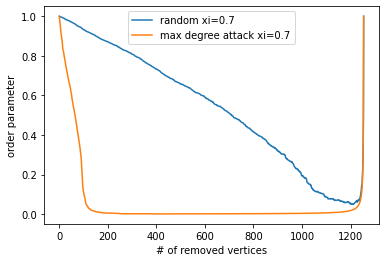

In [30]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/edge07.dat',directed=False).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random xi=0.7", "max degree attack xi=0.7"])
plt.savefig('op_community07.eps', format='eps')

node count: 1226
mean degree: 3.1794453507340945


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


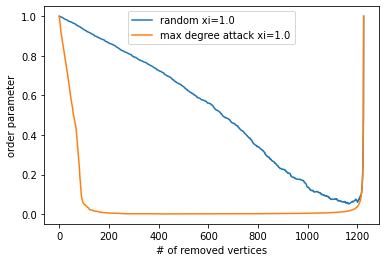

In [31]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/edge10.dat',directed=False).clusters().giant()
print("node count:", g.vcount())
print("mean degree:", np.mean(g.degree()))
g_rnd = [single_run(g, True)[0] for i in range(16)]
g_attack = [single_run(g, False)[0] for i in range(16)]
plt.plot(np.average(g_rnd, axis=0))
plt.plot(np.average(g_attack, axis=0))
plt.xlabel("# of removed vertices")
plt.ylabel("order parameter")
plt.legend(["random xi=1.0", "max degree attack xi=1.0"])
plt.savefig('op_community10.eps', format='eps')

As you can see - in this case we do not see a significant influence of $\xi$ parameter on the results.